In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
train  = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Hashtag,tweet,split
0,#climatechange,RT @climateguyw: #Parents please buy this book...,0.218829
1,#climatechange,RT @FintechSIN: Singapore Fintech Festival 201...,-0.026384
2,#climatechange,@AnthonyCole68 well prime minister,1.060947
3,#climatechange,RT @drkerrynphelps: We will never be able to s...,-1.391902
4,#climatechange,RT @AgentMacaron: 1/2,0.142273


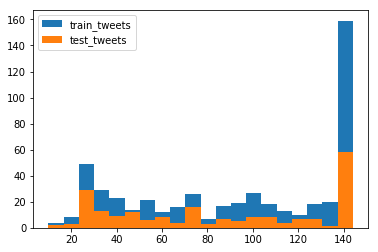

In [30]:
#check the length of tweets in both train and test
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

In [4]:
combi = train.append(test, ignore_index=True)

In [5]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [6]:
# remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

In [7]:
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [8]:
#remove short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [9]:
combi.head()

,Hashtag,tweet,split,tidy_tweet
0,#climatechange,RT @climateguyw: #Parents please buy this book...,0.218829,#Parents please this book begin educating your...
1,#climatechange,RT @FintechSIN: Singapore Fintech Festival 201...,-0.026384,Singapore Fintech Festival Kicks Tomorrow With...
2,#climatechange,@AnthonyCole68 well prime minister,1.060947,well prime minister
3,#climatechange,RT @drkerrynphelps: We will never be able to s...,-1.391902,will never able were warned
4,#climatechange,RT @AgentMacaron: 1/2,0.142273,


In [10]:
#tokenisation
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [#Parents, please, this, book, begin, educatin...
1    [Singapore, Fintech, Festival, Kicks, Tomorrow...
2                              [well, prime, minister]
3                    [will, never, able, were, warned]
4                                                   []
Name: tidy_tweet, dtype: object

In [11]:
#stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

0    [#parent, pleas, thi, book, begin, educ, your,...
1    [singapor, fintech, festiv, kick, tomorrow, wi...
2                                [well, prime, minist]
3                       [will, never, abl, were, warn]
4                                                   []
Name: tidy_tweet, dtype: object

In [12]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

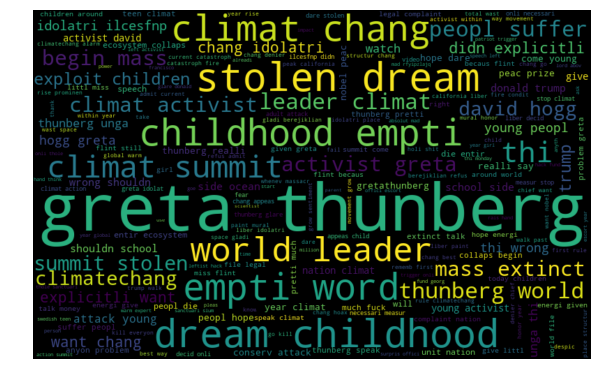

In [13]:
#most common words used
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

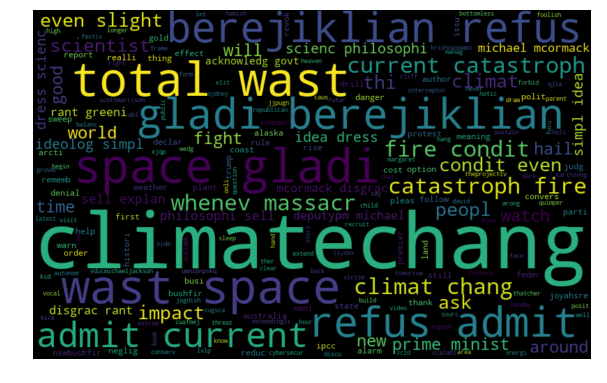

In [14]:
#words with #climatechange
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['Hashtag'] == '#climatechange']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

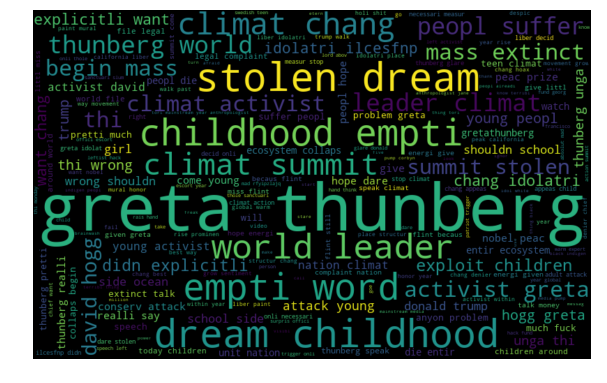

In [15]:
#words with Greta Thunberg
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['Hashtag'] == 'Greta Thunberg']])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
# collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [19]:
# extracting hashtags for climatechange

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['Hashtag'] == '#climatechange'])

# extracting hashtags from racist/sexist tweets
HT_name = hashtag_extract(combi['tidy_tweet'][combi['Hashtag'] == 'Greta Thunberg'])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_name = sum(HT_name,[])

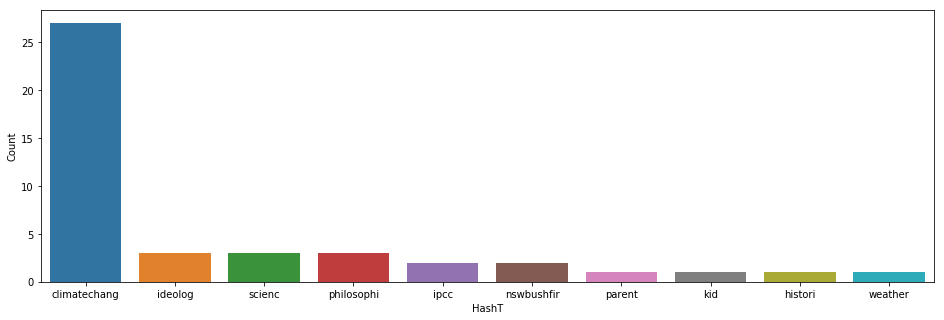

In [20]:
# hashtag with climatechange

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'HashT': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "HashT", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

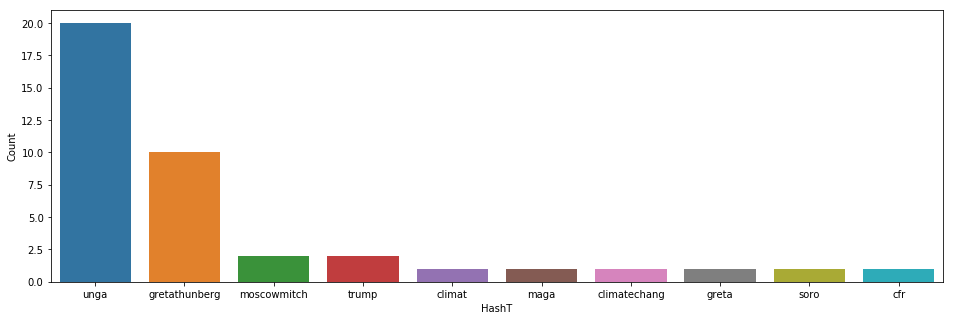

In [21]:
# hashtag with name
b = nltk.FreqDist(HT_name)
e = pd.DataFrame({'HashT': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "HashT", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(720, 485)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(720, 485)

In [45]:
#word embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(68280, 111880)

In [46]:
#Let's play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out
#the most similar words from the corpus.
model_w2v.wv.most_similar(positive="environment")

[('protest', 0.9935893416404724),
 ('consid', 0.9908252954483032),
 ('down', 0.9903819561004639),
 ('effect', 0.9897456765174866),
 ('agenda', 0.9886484146118164),
 ('show', 0.9885332584381104),
 ('arcti', 0.9882731437683105),
 ('#globalwarm', 0.9881185293197632),
 ('gold', 0.9881031513214111),
 ('premier', 0.9880732893943787)]

In [47]:
model_w2v.wv.most_similar(positive="greta")

[('thunberg', 0.9781095385551453),
 ('more', 0.8824873566627502),
 ('quit', 0.8817586302757263),
 ('than', 0.8787132501602173),
 ('their', 0.8705288767814636),
 ('stare', 0.8676736950874329),
 ('speech', 0.8633885383605957),
 ('member', 0.8623608350753784),
 ('straight', 0.8606513738632202),
 ('intellig', 0.8574459552764893)]

In [48]:
model_w2v['global']

array([ 0.00438684, -0.05019788, -0.03991463, -0.1963424 ,  0.14105524,
       -0.22598022, -0.15926279,  0.4578037 ,  0.03657868, -0.08347803,
       -0.2536085 ,  0.12137397,  0.16266379,  0.01012967, -0.04504853,
       -0.27507442, -0.34202474, -0.2687065 ,  0.11000466, -0.0832276 ,
        0.13516295, -0.16299367, -0.0442913 ,  0.00071891,  0.02011558,
       -0.02509234,  0.04474979, -0.06988635, -0.10557297, -0.23639613,
        0.09803502, -0.19228384,  0.24621621, -0.02302926,  0.37346613,
        0.05362282, -0.0696217 , -0.08148316, -0.05411313, -0.28437743,
       -0.2090035 ,  0.00269939,  0.21729381, -0.13050476,  0.41279715,
        0.00411254,  0.05572153,  0.12609793,  0.00750647, -0.0595501 ,
       -0.19908272,  0.06396382,  0.03271892, -0.03536062, -0.28222018,
       -0.04774876, -0.2461368 , -0.16399658,  0.19343325, -0.03263441,
        0.14235121,  0.23361287,  0.2724576 ,  0.07798264, -0.21252   ,
        0.28758267,  0.00731018, -0.07707635,  0.36788842,  0.07

In [49]:
len(model_w2v['global']) #The length of the vector is 200

200

In [50]:
#preparing vectors for each tweet
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [51]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(720, 200)

In [52]:
# Doc2vec embedding
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

In [53]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [54]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets

In [55]:
labeled_tweets[:6]

[LabeledSentence(words=['#parent', 'pleas', 'thi', 'book', 'begin', 'educ', 'your', '#kid', '#histori', '#climatechang', '#weather', 'world', 'ther'], tags=['tweet_0']),
 LabeledSentence(words=['singapor', 'fintech', 'festiv', 'kick', 'tomorrow', 'with', 'focu', 'sustain'], tags=['tweet_1']),
 LabeledSentence(words=['well', 'prime', 'minist'], tags=['tweet_2']),
 LabeledSentence(words=['will', 'never', 'abl', 'were', 'warn'], tags=['tweet_3']),
 LabeledSentence(words=[], tags=['tweet_4']),
 LabeledSentence(words=['know', 'sunday', 'holi'], tags=['tweet_5'])]

In [56]:
#train doc2vec model
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

C:\Users\sumat\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 724196.37it/s]


In [57]:
model_d2v.train(labeled_tweets, total_examples= len(combi['tidy_tweet']), epochs=15)

In [58]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(720, 200)

# Model Building
We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

Logistic Regression
Support Vector Machine
RandomForest
XGBoost

In [101]:
##logistic regression
# building model using bag of words
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [102]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

TypeError: 'module' object is not subscriptable

In [103]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

NameError: name 'xtrain_bow' is not defined

In [ ]:
#model to predict on test data
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

In [75]:
#building model using TD-IDF features
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[Ytrain.index]
xvalid_tfidf = train_tfidf[Yvalid.index]

NameError: name 'Ytrain' is not defined

In [76]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

NameError: name 'xtrain_tfidf' is not defined

In [77]:
#doc2vect features
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

NameError: name 'ytrain' is not defined

In [84]:
lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

NameError: name 'xvalid_d2v' is not defined

In [85]:
# Support vector machines SVM
from sklearn import svm


In [95]:
#bag of words features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

NameError: name 'xtrain_bow' is not defined

In [89]:
test_pred = svc.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_svc_bow.csv', index=False)

NameError: name 'svc' is not defined

In [ ]:
#Td-IDF features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

In [90]:
#word2vec features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

NameError: name 'xtrain_w2v' is not defined

In [96]:
#doc2vec features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

NameError: name 'xtrain_d2v' is not defined

In [97]:
#random forest
from sklearn.ensemble import RandomForestClassifier

In [98]:
#bag of words
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

NameError: name 'xtrain_bow' is not defined

In [99]:
#bag of words
test_pred = rf.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_rf_bow.csv', index=False)

NameError: name 'rf' is not defined

In [ ]:
#TF-IDF
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

In [ ]:
#word2vec 
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

In [ ]:
#doc2vec
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)